In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220616_VARprocess_EC_50subjects_180.0s_segment_1200.0s_VARlength/"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010072_EC    28
sub-010010_EC    30
sub-010148_EC    30
sub-010226_EC    30
sub-010074_EC    30
sub-010168_EC    27
sub-010086_EC    30
sub-010003_EC    30
sub-010041_EC    30
sub-010228_EC    28
sub-010194_EC    28
sub-010022_EC    28
sub-010056_EC    28
sub-010049_EC    16
sub-010038_EC    30
sub-010012_EC    30
sub-010191_EC    30
sub-010005_EC    30
sub-010195_EC    19
sub-010138_EC    30
sub-010063_EC    30
sub-010152_EC    30
sub-010004_EC    30
sub-010089_EC    30
sub-010053_EC    30
sub-010218_EC    30
sub-010276_EC    14
sub-010093_EC    30
sub-010214_EC    30
sub-010134_EC    25
sub-010223_EC    30
sub-010242_EC    29
sub-010243_EC    30
sub-010251_EC    30
sub-010291_EC    14
sub-010258_EC    28
sub-010236_EC    30
sub-010239_EC    16
sub-010248_EC    29
sub-010267_EC    30
sub-010265_EC    29
sub-010268_EC    30
sub-010303_EC    30
sub-010252_EC    30
sub-010288_EC    27
sub-010289_EC    28
sub-010272_EC    28
sub-010250_EC    30
sub-010295_EC    29
sub-010298_EC    24


30.0

27.84

<AxesSubplot:xlabel='order', ylabel='AIC'>

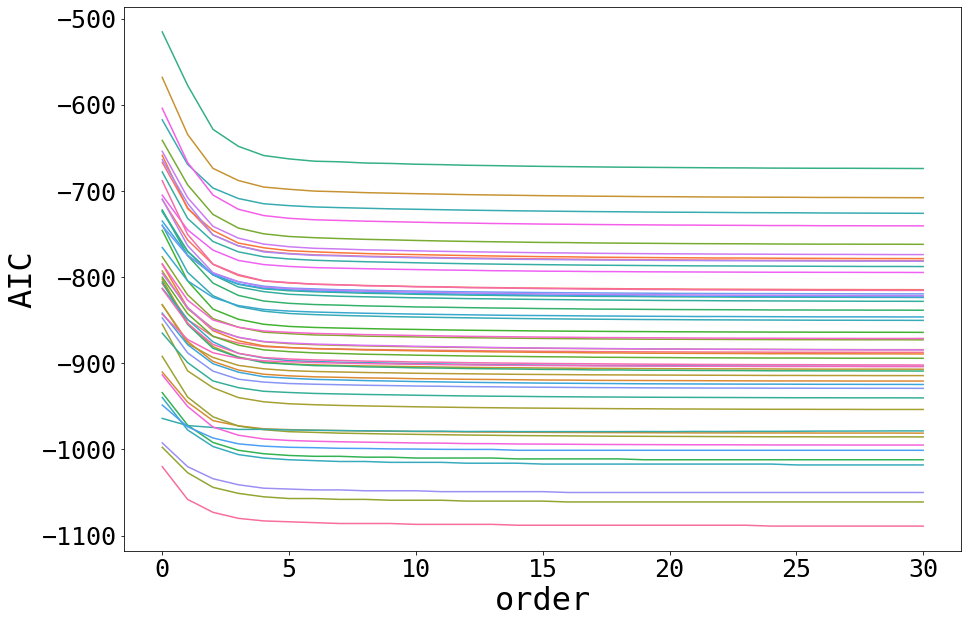

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_11266/171016283.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_11266/171016283.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


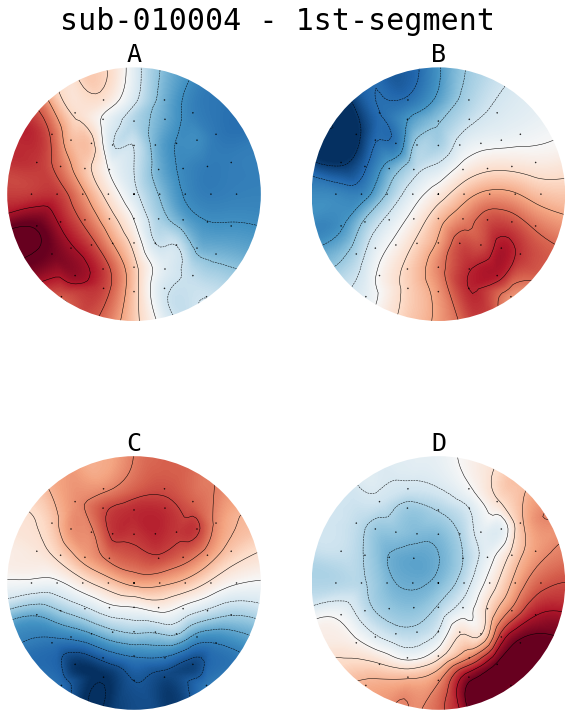

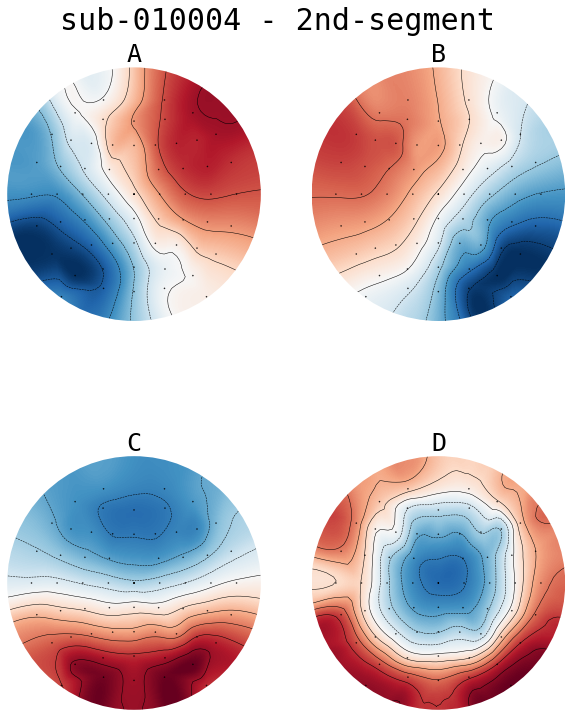

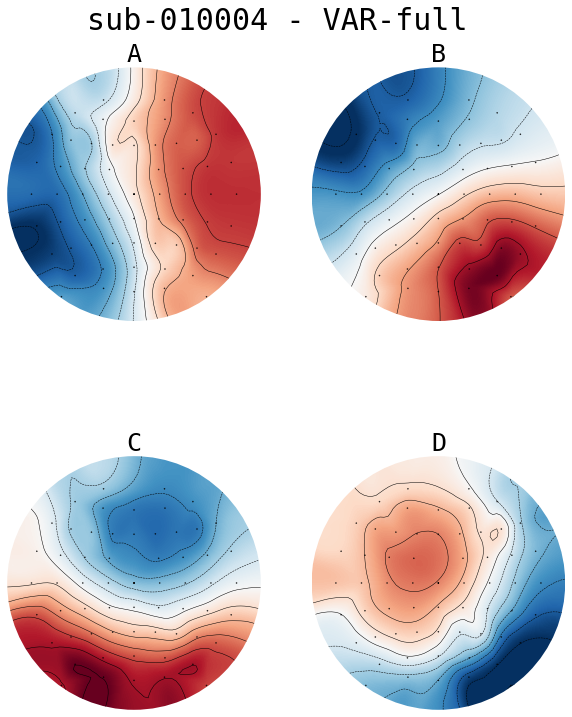

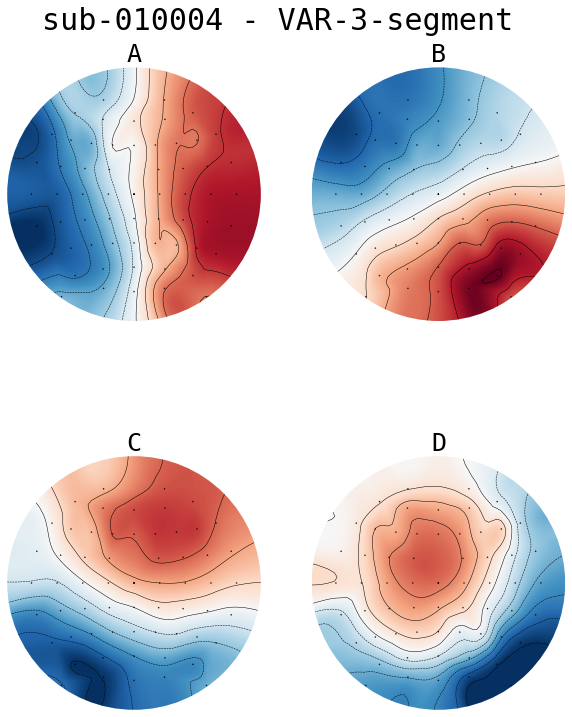

In [5]:
subj_id = "sub-010004"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-3-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
all_corrs = []
TYPES = list(topomaps["type"].values)
for typ1 in TYPES:
    for typ2 in TYPES:
        all_corrs.append(
            xr.corr(
                topomaps.sel({"type": typ1}),
                topomaps.sel({"type": typ2}),
                dim="channels",
            )
            .assign_coords({"type1": typ1, "type2": typ2})
            .expand_dims(["type1", "type2"])
        )

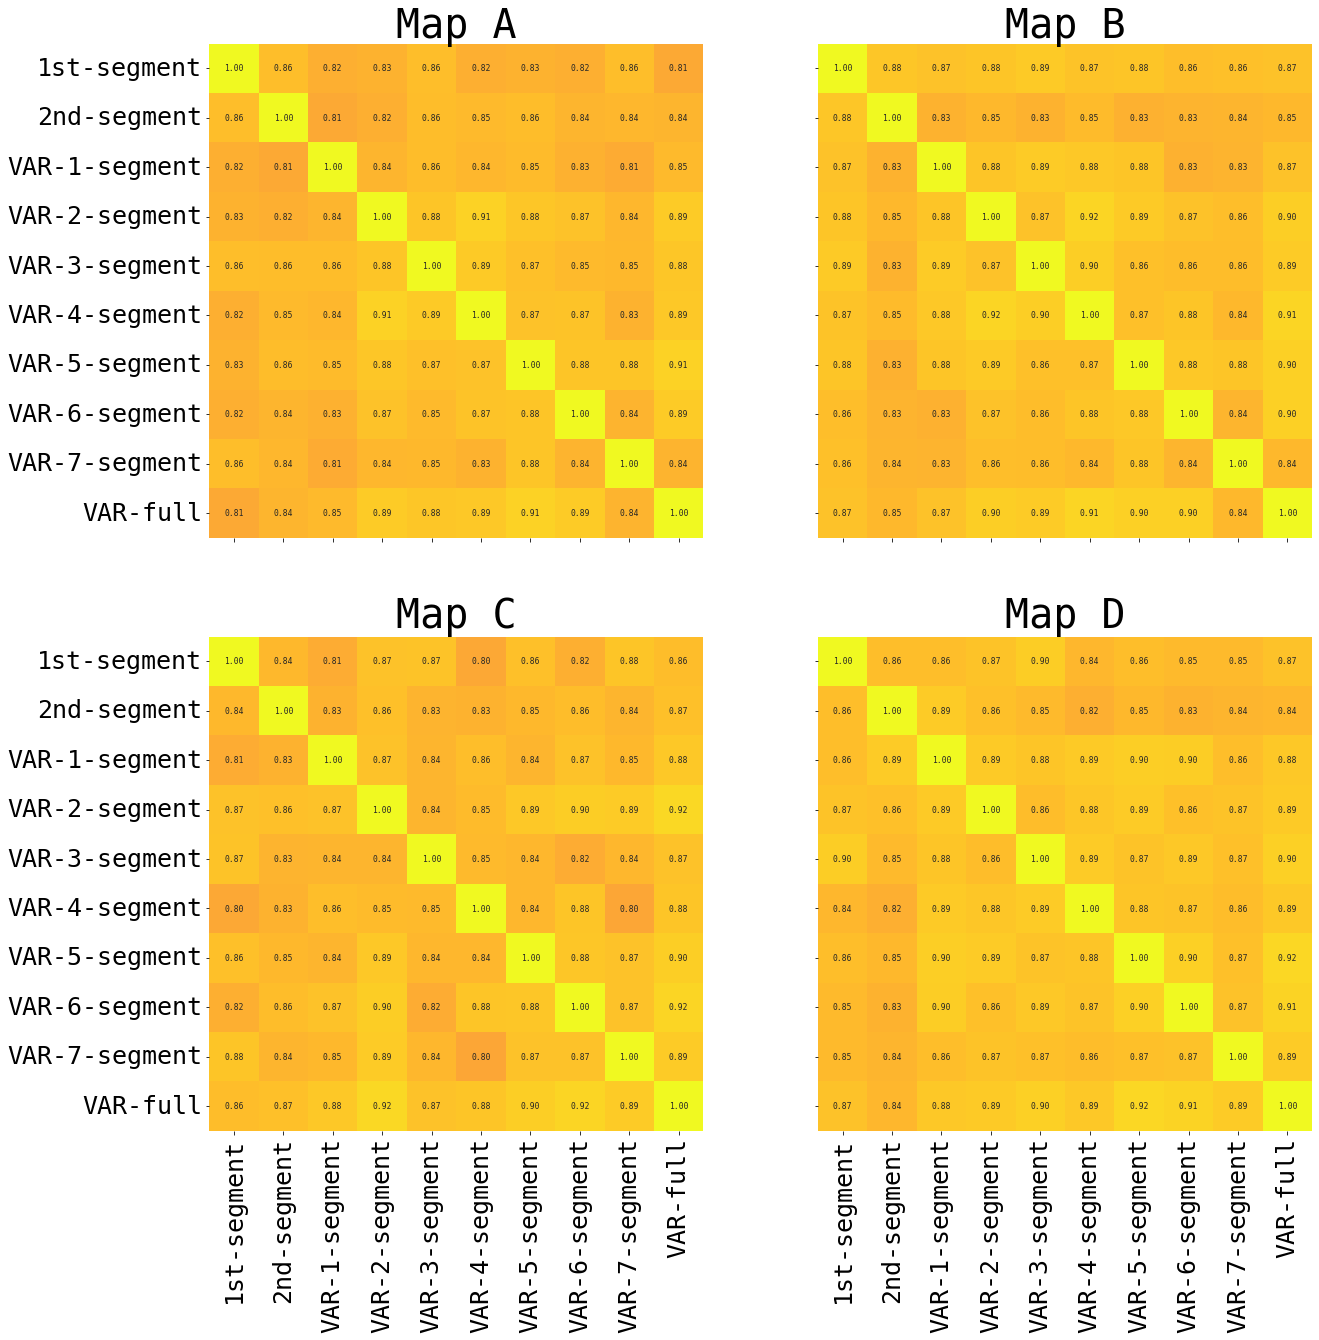

In [7]:
corrs = np.abs(xr.combine_by_coords(all_corrs))
corrs

fig, axs = plt.subplots(
    nrows=2, ncols=2, squeeze=True, figsize=(20, 20), sharey=True, sharex=True
)
axs = axs.flatten()
for i, lamap in enumerate(corrs["latent map"]):
    sns.heatmap(
        corrs.mean(dim="subject_id").sel({"latent map": lamap}),
        square=True,
        ax=axs[i],
        cbar=False,
        cmap="plasma",
        annot_kws={"size": 8},
        annot=True,
        vmin=0,
        vmax=1,
        fmt=".2f",
    )
    axs[i].set_xticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=90)
    axs[i].set_yticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=0)
    axs[i].set_title(f"Map {lamap.values}")

In [8]:
TYPES = ["1st-segment", "2nd-segment", "VAR-full"]
SUBJECTS = np.unique(topomaps.coords["subject_id"].values)


def _compute_corr(args):
    topomaps, typ1, typ2, subj1, subj2 = args
    return (
        xr.corr(
            topomaps.sel({"type": typ1, "subject_id": subj1}),
            topomaps.sel({"type": typ2, "subject_id": subj2}),
            dim="channels",
        )
        .assign_coords({"type1": typ1, "type2": typ2, "subj1": subj1, "subj2": subj2})
        .expand_dims(["type1", "type2", "subj1", "subj2"])
    )


all_corrs2 = run_in_parallel(
    _compute_corr,
    [
        (topomaps, typ1, typ2, subj1, subj2)
        for typ1 in TYPES
        for typ2 in TYPES
        for subj1 in SUBJECTS
        for subj2 in SUBJECTS
    ],
)

combined = np.abs(xr.combine_by_coords(all_corrs2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22500/22500 [01:07<00:00, 331.84it/s]


Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

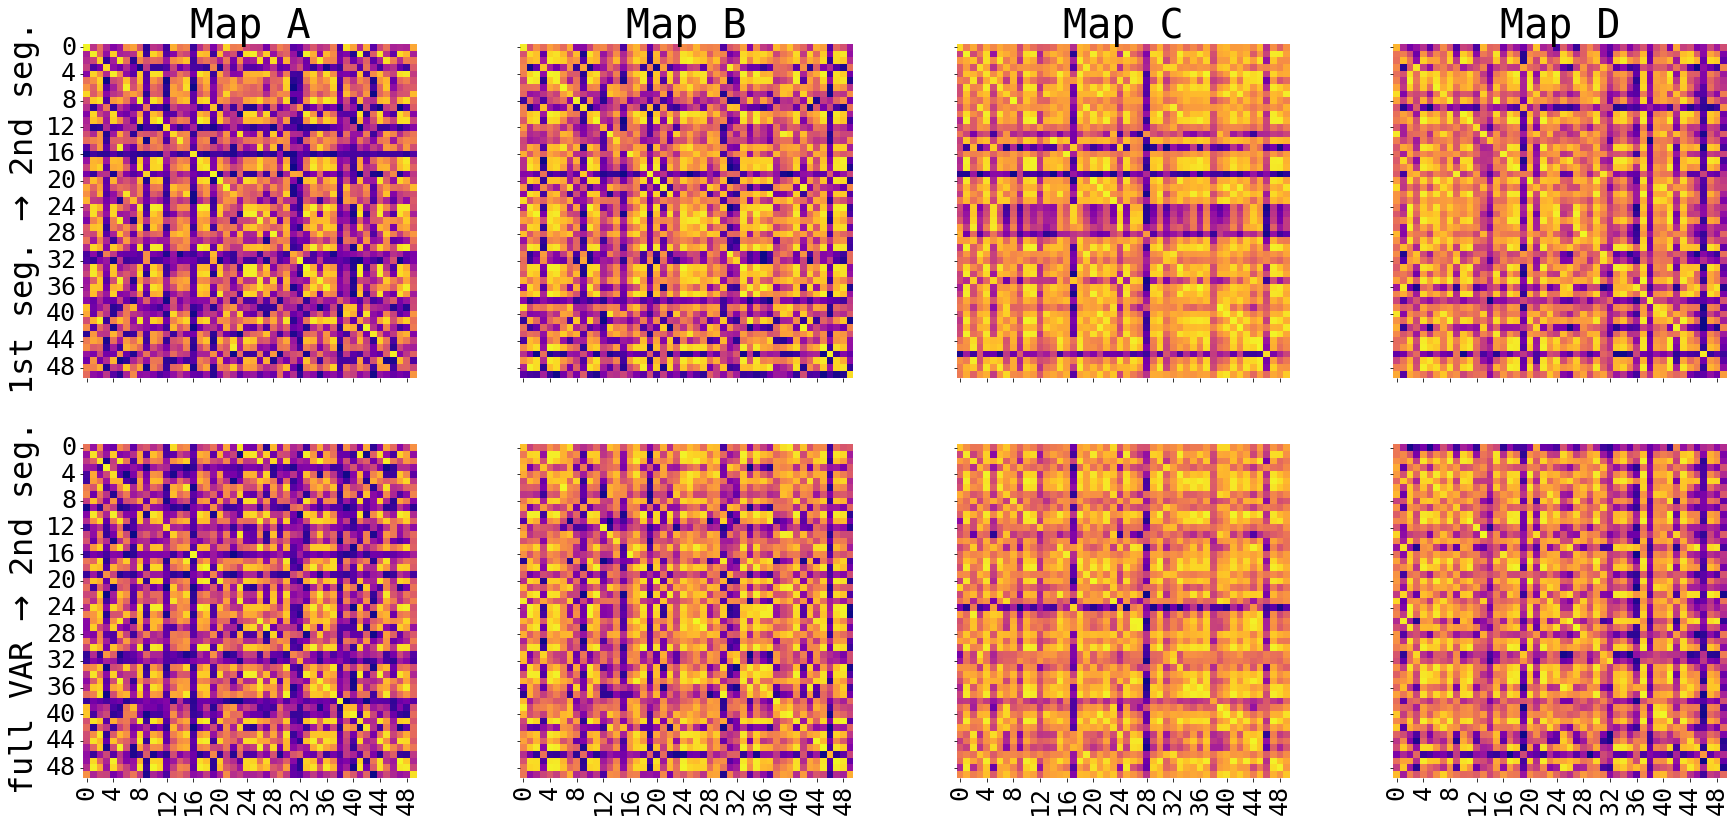

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

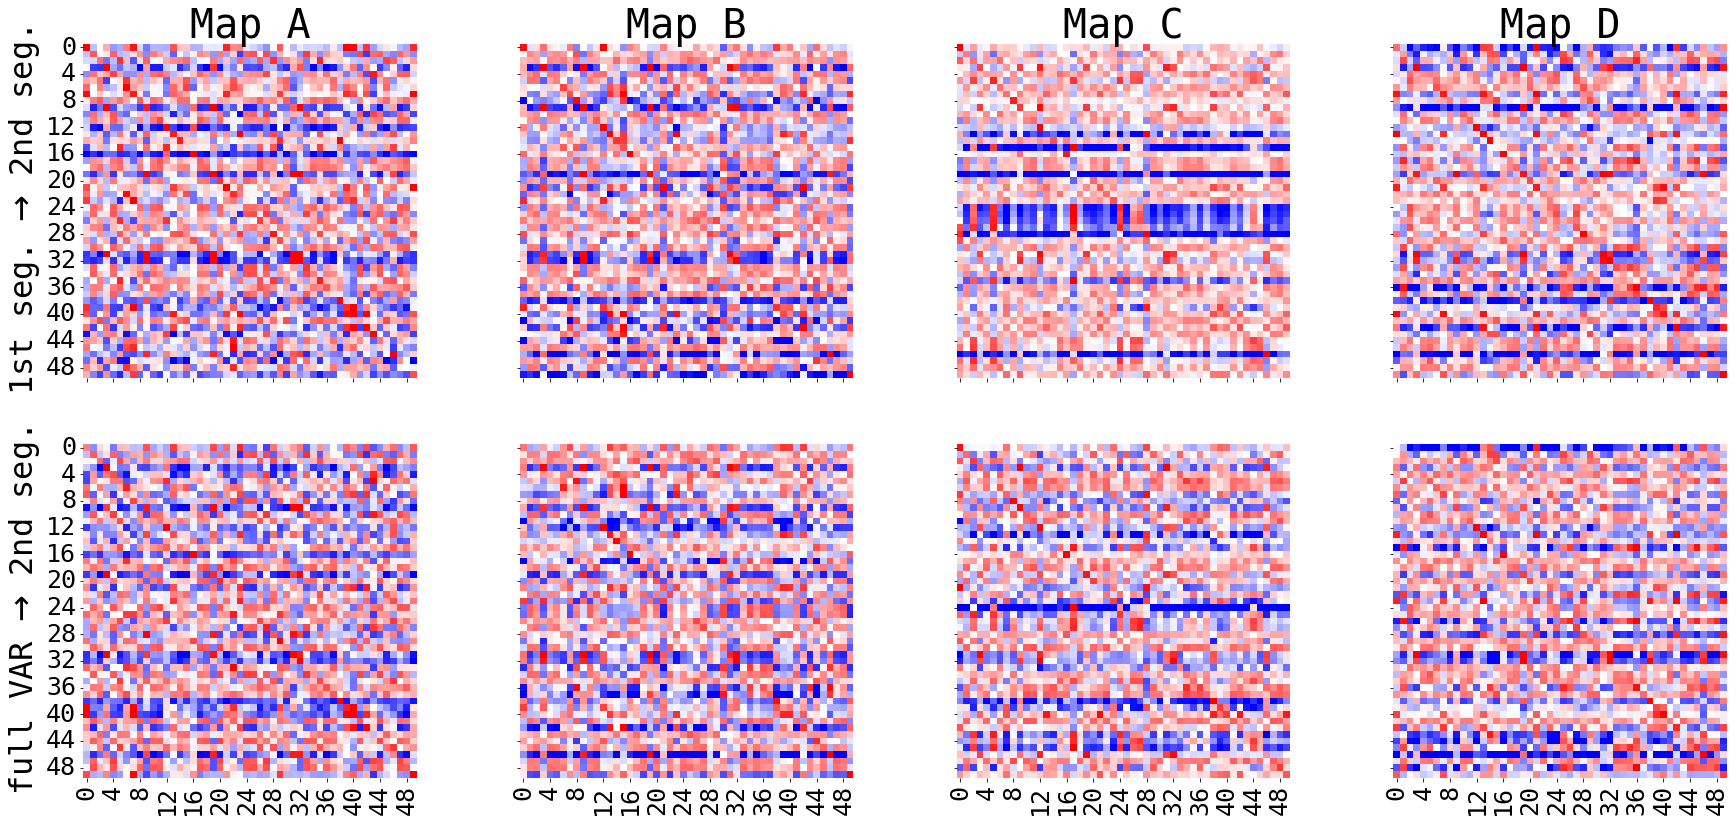

In [10]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

In [11]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

,A,B,C,D
1st-segment,25,23,21,20
VAR-full,20,20,18,15


,A,B,C,D
1st-segment,25,23,21,20
VAR-full,20,20,18,15


# Static and dynamic stats

In [12]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010003 1st-segment       A           0.724584   0.671323       0.932505   
                             B           0.724584   0.671323       0.825621   
                             C           0.724584   0.671323       0.952080   
                             D           0.724584   0.671323       0.705231   
           2nd-segment       A           0.718232   0.663086       0.917768   
...                                           ...        ...            ...   
sub-010298 VAR-segments-mean D           0.715369   0.663705       0.897498   
sub-010303 VAR-segments-mean A           0.692783   0.631124       0.833846   
                             B           0.692783   0.631124       0.839033   
                             C           0.692783   0.631124       0.945573   
                             D           0.692783   0.631124       0.910224   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010003 1st-segment       A           0.221884   11.321971  19.597645   
                             B           0.309504   13.399702  23.104106   
                             C           0.264194   12.660830  20.867047   
                             D           0.204418   11.983067  17.057024   
           2nd-segment       A           0.221862   11.710851  18.944972   
...                                           ...         ...        ...   
sub-010298 VAR-segments-mean D           0.254086   11.204549  22.680379   
sub-010303 VAR-segments-mean A           0.242486   14.731071  16.459912   
                             B           0.240757   15.013204  16.038425   
                             C           0.255530   14.242189  17.970554   
                             D           0.261227   14.245758  18.371606   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010003 1st-segment       A                0.795894       0.077817   
                             B                0.056648       0.826824   
                             C                0.059299       0.057280   
                             D                0.059143       0.103609   
           2nd-segment       A                0.788862       0.069511   
...                                                ...            ...   
sub-010298 VAR-segments-mean D                0.059564       0.060348   
sub-010303 VAR-segments-mean A                0.756292       0.080423   
                             B                0.080887       0.750066   
                             C                0.080069       0.079086   
                             D                0.073135       0.078175   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010003 1st-segment       A                0.068302       0.057987  
                             B                0.067275       0.049253  
                             C                0.808310       0.075111  
                             D                0.071755       0.765492  
           2nd-segment       A                0.059595       0.082031  
...                                                ...            ...  
sub-010298 VAR-segments-mean D                0.056881       0.823207  
sub-010303 VAR-segments-mean A                0.083460       0.079826  
                             B                0.080280       0.088767  
                             C                0.776862       0.063982  
                             D                0.067065       0.781625  

[800 rows x 10 columns]

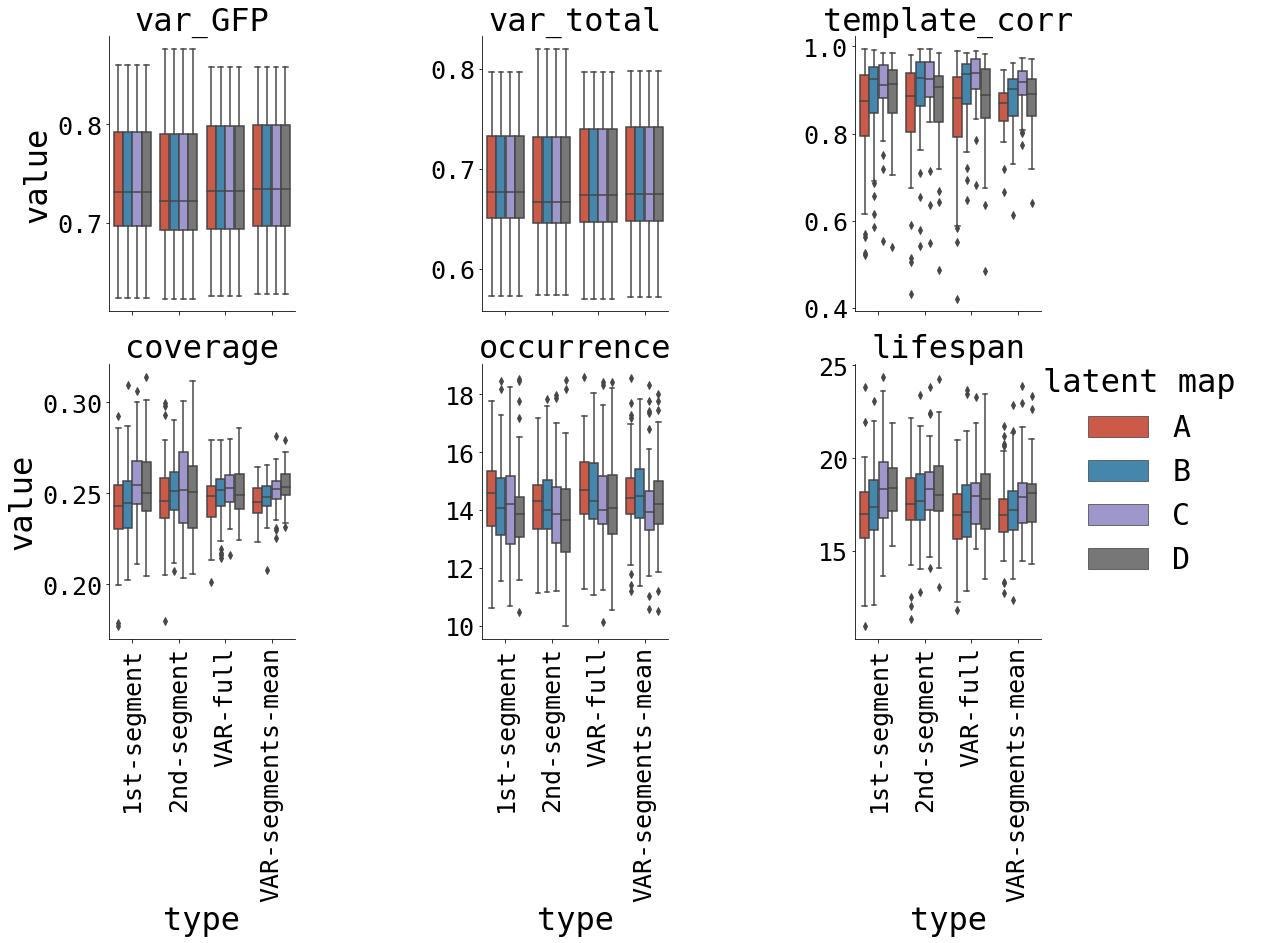

In [13]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [14]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
static_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [15]:
DVS = ["var_GFP", "var_total", "template_corr", "coverage", "occurrence", "lifespan"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=static_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,5.574268,0.005096,0.005782,0.508714


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,11.097946,49.0,two-sided,5.665259e-15,3.115892e-14,fdr_by,1.218e+12,0.080705
1,diffs,VAR-full,real_data,True,True,-1.482581,49.0,two-sided,1.445892e-01,2.650803e-01,fdr_by,0.428,-0.101422
2,diffs,VAR-segments,real_data,True,True,-2.765707,49.0,two-sided,7.986559e-03,2.196304e-02,fdr_by,4.561,-0.186040


== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,1.218173,0.300209,0.00127,0.503924


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,14.384198,49.0,two-sided,3.240806e-19,1.782443e-18,fdr_by,1.562e+16,0.068992
1,diffs,VAR-full,real_data,True,True,-0.103391,49.0,two-sided,9.180743e-01,1.000000e+00,fdr_by,0.155,-0.007058
2,diffs,VAR-segments,real_data,True,True,-1.159221,49.0,two-sided,2.519842e-01,6.929565e-01,fdr_by,0.289,-0.078556


== template_corr ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,0.851496,0.429909,0.004443,0.633187


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-1.626282,49.0,two-sided,0.110305,0.606676,fdr_by,0.525,-0.134284
1,diffs,VAR-full,real_data,True,True,-0.919757,49.0,two-sided,0.362206,0.996066,fdr_by,0.229,-0.136397
2,diffs,VAR-segments,real_data,True,True,-0.174119,49.0,two-sided,0.862489,1.000000,fdr_by,0.156,-0.021098


== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,2.442373,0.092231,0.009173,0.929326


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-2.099649,49.0,two-sided,0.040932,0.225128,fdr_by,1.15,-0.215265
1,diffs,VAR-full,real_data,True,True,-1.733777,49.0,two-sided,0.089246,0.245427,fdr_by,0.617,-0.189190
2,diffs,VAR-segments,real_data,True,True,-0.074862,49.0,two-sided,0.940629,1.000000,fdr_by,0.154,-0.007587


== occurrence ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,17.992888,2.209030e-07,0.000068,0.036156,0.530034,False,0.113328,2.014306e-23


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-4.631146,49.0,two-sided,0.000027,0.000084,fdr_by,762.484,-0.084712
1,diffs,VAR-full,real_data,True,True,-4.594048,49.0,two-sided,0.000031,0.000084,fdr_by,679.887,-0.452388
2,diffs,VAR-segments,real_data,True,True,-3.807727,49.0,two-sided,0.000391,0.000717,fdr_by,66.318,-0.358842


== lifespan ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,10.729335,0.000061,0.001739,0.024601,0.515735,False,0.061021,7.105222e-30


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,4.585875,49.0,two-sided,0.000031,0.000173,fdr_by,662.961,0.062673
1,diffs,VAR-full,real_data,True,True,3.546173,49.0,two-sided,0.000872,0.002397,fdr_by,32.211,0.374552
2,diffs,VAR-segments,real_data,True,True,2.932545,49.0,two-sided,0.005099,0.009349,fdr_by,6.735,0.302233


In [16]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010003 1st-segment           3.945445  1.981170          2.0   
           2nd-segment           3.650668  1.987138          2.0   
           VAR-full              4.077986  1.998594          2.0   
sub-010004 1st-segment           3.592653  1.991128          2.0   
           2nd-segment           3.515078  1.995672          2.0   
...                                   ...       ...          ...   
sub-010289 VAR-segments-mean     3.717608  1.995462          2.0   
sub-010291 VAR-segments-mean     3.570187  1.996169          2.0   
sub-010295 VAR-segments-mean     3.722501  1.995068          2.0   
sub-010298 VAR-segments-mean     4.436407  1.996652          2.0   
sub-010303 VAR-segments-mean     3.553348  1.997843          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010003 1st-segment            0.995264         1.024063     52.000000  
           2nd-segment            1.018983         1.048634     52.000000  
           VAR-full               0.999053         1.022529     56.000000  
sub-010004 1st-segment            1.089501         1.119791     48.000000  
           2nd-segment            1.097161         1.127991     52.000000  
...                                    ...              ...           ...  
sub-010289 VAR-segments-mean      1.015065         1.053174     56.000000  
sub-010291 VAR-segments-mean      1.087489         1.112156     56.000000  
sub-010295 VAR-segments-mean      1.058478         1.093139     53.714286  
sub-010298 VAR-segments-mean      0.944402         0.963647     73.714286  
sub-010303 VAR-segments-mean      1.117694         1.149648     42.857143  

[200 rows x 6 columns]

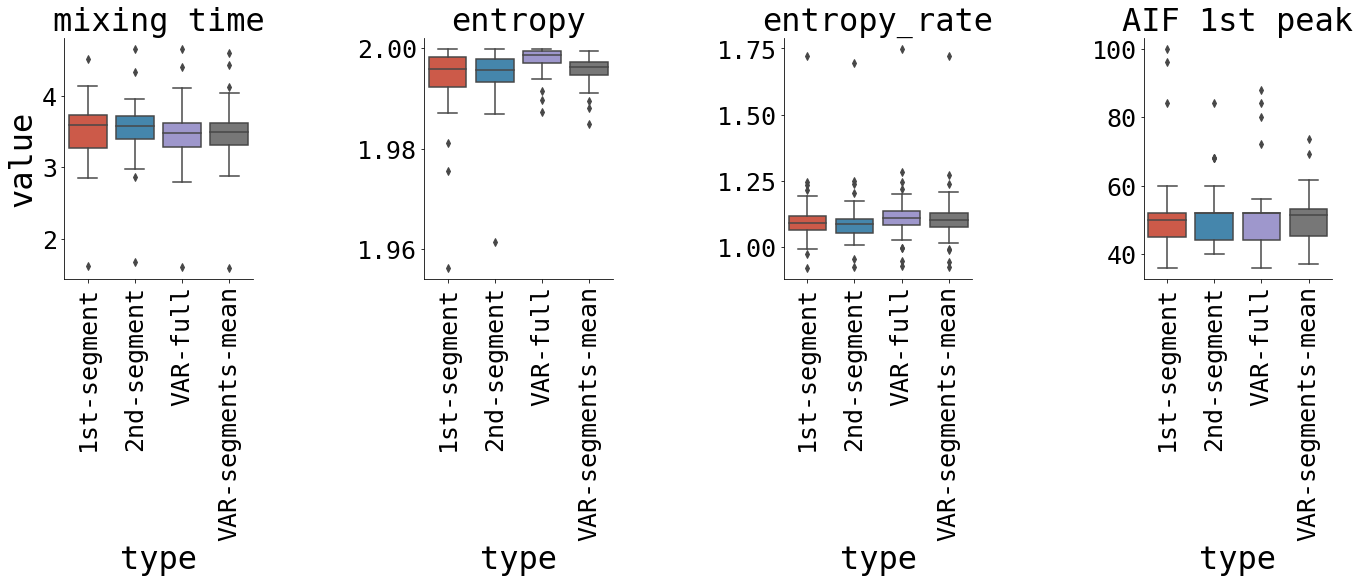

In [17]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [18]:
dynamic_stats

,subject_id,mixing time,entropy,max entropy,entropy_rate,MC entropy rate,AIF 1st peak,type
0,sub-010003,3.945445,1.981170,2.0,0.995264,1.024063,52.0,1st-segment
0,sub-010003,3.650668,1.987138,2.0,1.018983,1.048634,52.0,2nd-segment
0,sub-010003,4.009298,1.997401,2.0,0.991267,1.016721,56.0,VAR-1-segment
0,sub-010003,3.993238,1.999445,2.0,0.986120,1.011840,56.0,VAR-2-segment
0,sub-010003,4.060673,1.998081,2.0,0.992311,1.017787,56.0,VAR-3-segment
...,...,...,...,...,...,...,...,...
0,sub-010303,3.600976,1.998883,2.0,1.119388,1.150849,44.0,VAR-4-segment
0,sub-010303,3.461179,1.998298,2.0,1.119906,1.151865,44.0,VAR-5-segment
0,sub-010303,3.591566,1.997282,2.0,1.120048,1.152235,40.0,VAR-6-segment
0,sub-010303,3.588803,1.997668,2.0,1.109095,1.142401,40.0,VAR-7-segment


In [19]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
dynamic_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [20]:
dynamic_diffs

,subject_id,mixing time,entropy,entropy_rate,AIF 1st peak,diffs
0,sub-010003,-0.294777,0.005967,0.023718,0.000000,real_data
1,sub-010004,-0.077575,0.004544,0.007660,4.000000,real_data
2,sub-010005,-0.001416,-0.002418,0.003494,-4.000000,real_data
3,sub-010010,-0.086794,-0.000970,-0.008654,0.000000,real_data
4,sub-010012,0.133762,-0.005476,-0.010073,0.000000,real_data
...,...,...,...,...,...,...
145,sub-010289,-0.186752,-0.006143,-0.005170,0.000000,VAR-segments
146,sub-010291,0.213708,-0.005915,-0.038344,-4.000000,VAR-segments
147,sub-010295,0.015125,-0.001309,-0.010305,-1.714286,VAR-segments
148,sub-010298,0.228118,0.002137,-0.018623,-5.714286,VAR-segments


In [21]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== mixing time ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,3.018141,0.053459,0.079428,0.011984,0.613607,False,0.370292,4.416405e-11


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,1.914525,49.0,two-sided,0.061401,0.168854,fdr_by,0.829,0.094416
1,diffs,VAR-full,real_data,True,True,1.949695,49.0,two-sided,0.056947,0.168854,fdr_by,0.88,0.266316
2,diffs,VAR-segments,real_data,True,True,1.373270,49.0,two-sided,0.175920,0.322520,fdr_by,0.371,0.170109


== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,11.614917,0.00003,0.081249,0.576328


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-7.281480,49.0,two-sided,2.433397e-09,1.338368e-08,fdr_by,4.812e+06,-0.406797
1,diffs,VAR-full,real_data,True,True,-3.898235,49.0,two-sided,2.945465e-04,8.100027e-04,fdr_by,85.718,-0.719173
2,diffs,VAR-segments,real_data,True,True,-1.719684,49.0,two-sided,9.180138e-02,1.683025e-01,fdr_by,0.604,-0.299881


== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,24.008428,3.268369e-09,0.056056,0.540861


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-11.946234,49.0,two-sided,3.987584e-16,2.193171e-15,fdr_by,1.582e+13,-0.269747
1,diffs,VAR-full,real_data,True,True,-5.636546,49.0,two-sided,8.453480e-07,2.324707e-06,fdr_by,1.917e+04,-0.608602
2,diffs,VAR-segments,real_data,True,True,-2.981578,49.0,two-sided,4.457019e-03,8.171202e-03,fdr_by,7.576,-0.308754


== AIF 1st peak ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,0.426077,0.65427,0.561508,0.002448,0.627557,False,0.40652,4.149110e-10


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-0.603217,49.0,two-sided,0.549147,1.0,fdr_by,0.183,-0.043271
1,diffs,VAR-full,real_data,True,True,0.470977,49.0,two-sided,0.639747,1.0,fdr_by,0.171,0.069731
2,diffs,VAR-segments,real_data,True,True,0.851784,49.0,two-sided,0.398478,1.0,fdr_by,0.217,0.123443
